In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

#import acquire
#import summarize
#import prepare

In [2]:
import pandas as pd
import numpy as np
import os
import env
from env import host, user, password

def get_connection(db):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'


def get_zillow_data():
    filename = "acquire_zillow_properties.csv"

    if os.path.isfile(filename):
        return pd.read_csv(filename)
    else:
        df = pd.read_sql("""
        WITH latest_transactions AS (
            SELECT parcelid, MAX(transactiondate) AS last_transaction_date
            FROM predictions_2017
            GROUP BY parcelid
        )

        SELECT 
            p.*, pred.logerror, pred.transactiondate,
            ac.airconditioningdesc,
            ast.architecturalstyledesc,
            bct.buildingclassdesc,
            hst.heatingorsystemdesc,
            plt.propertylandusedesc,
            st.storydesc,
            tct.typeconstructiondesc
        FROM properties_2017 p
        JOIN latest_transactions lt ON p.parcelid = lt.parcelid
        JOIN predictions_2017 pred ON p.parcelid = pred.parcelid AND lt.last_transaction_date = pred.transactiondate
        LEFT JOIN airconditioningtype ac ON p.airconditioningtypeid = ac.airconditioningtypeid
        LEFT JOIN architecturalstyletype ast ON p.architecturalstyletypeid = ast.architecturalstyletypeid
        LEFT JOIN buildingclasstype bct ON p.buildingclasstypeid = bct.buildingclasstypeid
        LEFT JOIN heatingorsystemtype hst ON p.heatingorsystemtypeid = hst.heatingorsystemtypeid
        LEFT JOIN propertylandusetype plt ON p.propertylandusetypeid = plt.propertylandusetypeid
        LEFT JOIN storytype st ON p.storytypeid = st.storytypeid
        LEFT JOIN typeconstructiontype tct ON p.typeconstructiontypeid = tct.typeconstructiontypeid
        WHERE p.latitude IS NOT NULL AND p.longitude IS NOT NULL
        """,get_connection('zillow'))

        # Write that dataframe to disk for later. Called "caching" the data for later.
        df.to_csv(filename)
        
        # Return the dataframe to the calling code
        return df

In [3]:
# Assuming you have the Zillow data in the 'df' variable
df = get_zillow_data()

In [4]:
df

,Unnamed: 0,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,0,1727539,14297519,NaN,NaN,NaN,3.50,4.00,NaN,NaN,...,"60,590,630,072,012.00",0.03,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1,1387261,17052889,NaN,NaN,NaN,1.00,2.00,NaN,NaN,...,"61,110,010,023,006.00",0.06,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,2,11677,14186244,NaN,NaN,NaN,2.00,3.00,NaN,NaN,...,"60,590,218,022,012.00",0.01,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,3,2288172,12177905,NaN,NaN,NaN,3.00,4.00,NaN,8.00,...,"60,373,001,001,006.00",-0.10,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,4,1970746,10887214,1.00,NaN,NaN,3.00,3.00,NaN,8.00,...,"60,371,236,012,000.00",0.01,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77376,77376,673515,11000655,NaN,NaN,NaN,2.00,2.00,NaN,6.00,...,"60,371,014,003,002.00",0.02,2017-09-20,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
77377,77377,2968375,17239384,NaN,NaN,NaN,2.00,4.00,NaN,NaN,...,"61,110,084,022,016.00",0.01,2017-09-21,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
77378,77378,1843709,12773139,1.00,NaN,NaN,1.00,3.00,NaN,4.00,...,"60,374,338,022,005.00",0.04,2017-09-21,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN
77379,77379,1187175,12826780,NaN,NaN,NaN,2.00,3.00,NaN,6.00,...,"60,375,034,021,020.00",0.01,2017-09-25,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN


In [5]:
def handle_missing_values(df, prop_required_column, prop_required_row):
    # Drop columns based on the proportion of missing values
    column_threshold = int(round(prop_required_column * len(df)))
    df = df.dropna(axis=1, thresh=column_threshold)

    # Drop rows based on the proportion of missing values
    row_threshold = int(round(prop_required_row * len(df.columns)))
    df = df.dropna(axis=0, thresh=row_threshold)

    return df

# Assuming you have the filtered Zillow data in the 'df' variable
prop_required_column = 0.6
prop_required_row = 0.75

In [6]:
# Handle missing values in the DataFrame
df = handle_missing_values(df, prop_required_column, prop_required_row)
df = df.drop("Unnamed: 0", axis=1)

In [7]:
df

,id,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc
0,1727539,14297519,3.50,4.00,NaN,3.50,"3,100.00","3,100.00","6,059.00",3.00,...,"485,713.00","1,023,282.00","2,016.00","537,569.00","11,013.72","60,590,630,072,012.00",0.03,2017-01-01,NaN,Single Family Residential
1,1387261,17052889,1.00,2.00,NaN,1.00,"1,465.00","1,465.00","6,111.00",1.00,...,"88,000.00","464,000.00","2,016.00","376,000.00","5,672.48","61,110,010,023,006.00",0.06,2017-01-01,NaN,Single Family Residential
2,11677,14186244,2.00,3.00,NaN,2.00,"1,243.00","1,243.00","6,059.00",2.00,...,"85,289.00","564,778.00","2,016.00","479,489.00","6,488.30","60,590,218,022,012.00",0.01,2017-01-01,NaN,Single Family Residential
3,2288172,12177905,3.00,4.00,8.00,3.00,"2,376.00","2,376.00","6,037.00",3.00,...,"108,918.00","145,143.00","2,016.00","36,225.00","1,777.51","60,373,001,001,006.00",-0.10,2017-01-01,Central,Single Family Residential
4,1970746,10887214,3.00,3.00,8.00,3.00,"1,312.00","1,312.00","6,037.00",3.00,...,"73,681.00","119,407.00","2,016.00","45,726.00","1,533.89","60,371,236,012,000.00",0.01,2017-01-01,Central,Condominium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77376,673515,11000655,2.00,2.00,6.00,2.00,"1,286.00","1,286.00","6,037.00",2.00,...,"70,917.00","354,621.00","2,016.00","283,704.00","4,478.43","60,371,014,003,002.00",0.02,2017-09-20,Central,Single Family Residential
77377,2968375,17239384,2.00,4.00,NaN,2.00,"1,612.00","1,612.00","6,111.00",2.00,...,"50,683.00","67,205.00","2,016.00","16,522.00","1,107.48","61,110,084,022,016.00",0.01,2017-09-21,NaN,Single Family Residential
77378,1843709,12773139,1.00,3.00,4.00,1.00,"1,032.00","1,032.00","6,037.00",1.00,...,"32,797.00","49,546.00","2,016.00","16,749.00",876.43,"60,374,338,022,005.00",0.04,2017-09-21,Central,Single Family Residential
77379,1187175,12826780,2.00,3.00,6.00,2.00,"1,762.00","1,762.00","6,037.00",2.00,...,"140,000.00","522,000.00","2,016.00","382,000.00","6,317.15","60,375,034,021,020.00",0.01,2017-09-25,Central,Single Family Residential


In [8]:
def filter_single_unit_properties(df):
    single_unit_ids = [261, 262, 263, 264, 266, 268, 273, 276, 279]
    return df[df['propertylandusetypeid'].isin(single_unit_ids)]

# Filter the DataFrame to keep only single-unit properties
df = filter_single_unit_properties(df)

In [9]:
df

,id,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc
0,1727539,14297519,3.50,4.00,NaN,3.50,"3,100.00","3,100.00","6,059.00",3.00,...,"485,713.00","1,023,282.00","2,016.00","537,569.00","11,013.72","60,590,630,072,012.00",0.03,2017-01-01,NaN,Single Family Residential
1,1387261,17052889,1.00,2.00,NaN,1.00,"1,465.00","1,465.00","6,111.00",1.00,...,"88,000.00","464,000.00","2,016.00","376,000.00","5,672.48","61,110,010,023,006.00",0.06,2017-01-01,NaN,Single Family Residential
2,11677,14186244,2.00,3.00,NaN,2.00,"1,243.00","1,243.00","6,059.00",2.00,...,"85,289.00","564,778.00","2,016.00","479,489.00","6,488.30","60,590,218,022,012.00",0.01,2017-01-01,NaN,Single Family Residential
3,2288172,12177905,3.00,4.00,8.00,3.00,"2,376.00","2,376.00","6,037.00",3.00,...,"108,918.00","145,143.00","2,016.00","36,225.00","1,777.51","60,373,001,001,006.00",-0.10,2017-01-01,Central,Single Family Residential
4,1970746,10887214,3.00,3.00,8.00,3.00,"1,312.00","1,312.00","6,037.00",3.00,...,"73,681.00","119,407.00","2,016.00","45,726.00","1,533.89","60,371,236,012,000.00",0.01,2017-01-01,Central,Condominium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77376,673515,11000655,2.00,2.00,6.00,2.00,"1,286.00","1,286.00","6,037.00",2.00,...,"70,917.00","354,621.00","2,016.00","283,704.00","4,478.43","60,371,014,003,002.00",0.02,2017-09-20,Central,Single Family Residential
77377,2968375,17239384,2.00,4.00,NaN,2.00,"1,612.00","1,612.00","6,111.00",2.00,...,"50,683.00","67,205.00","2,016.00","16,522.00","1,107.48","61,110,084,022,016.00",0.01,2017-09-21,NaN,Single Family Residential
77378,1843709,12773139,1.00,3.00,4.00,1.00,"1,032.00","1,032.00","6,037.00",1.00,...,"32,797.00","49,546.00","2,016.00","16,749.00",876.43,"60,374,338,022,005.00",0.04,2017-09-21,Central,Single Family Residential
77379,1187175,12826780,2.00,3.00,6.00,2.00,"1,762.00","1,762.00","6,037.00",2.00,...,"140,000.00","522,000.00","2,016.00","382,000.00","6,317.15","60,375,034,021,020.00",0.01,2017-09-25,Central,Single Family Residential


In [10]:
import pandas as pd

def custom_describe(df):
    desc = df.describe(include='all').T
    
    # Adding additional columns
    desc['count_nulls'] = df.isnull().sum()
    desc['pct_nulls'] = (desc['count_nulls'] / len(df)) * 100
    desc['num_rows_missing'] = len(df) - desc['count']
    desc['pct_rows_missing'] = (desc['num_rows_missing'] / len(df)) * 100
    desc['dtype'] = df.dtypes
    
    for col in df.columns:
        print("\nColumn:", col)
        
        if df[col].dtype != 'O':
            sns.histplot(df[col], kde=True)
            plt.title(f'Distribution of {col}')
            plt.show()
    
    # Reorder columns
    columns_order = [
        'num_rows_missing', 'pct_rows_missing',
        'count', 'count_nulls', 'pct_nulls', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'unique', 'top', 'freq', 'dtype'
    ]
    desc = desc[columns_order]
    
    return desc


Column: id


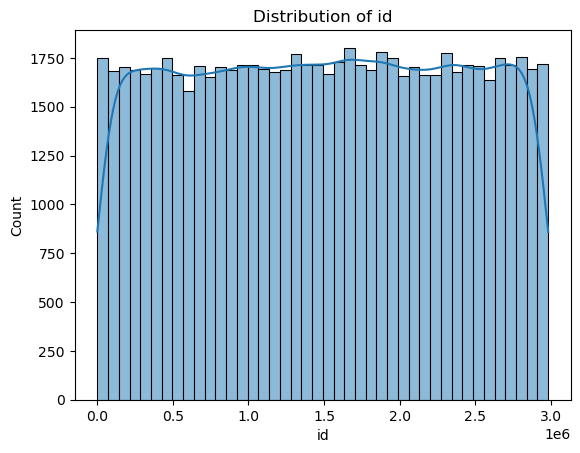


Column: parcelid


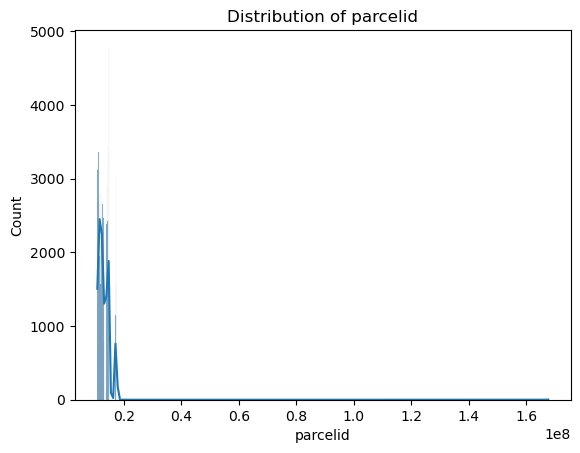


Column: bathroomcnt


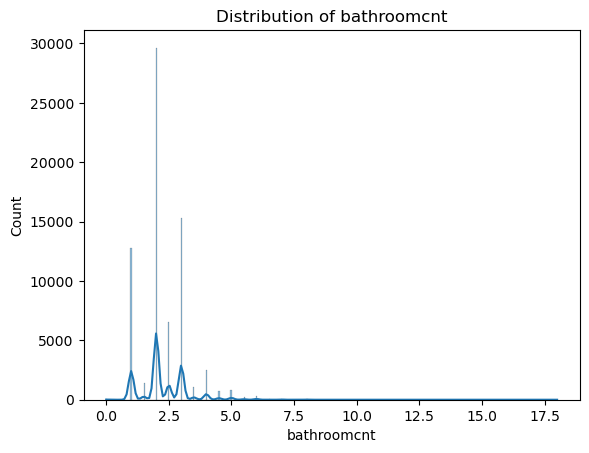


Column: bedroomcnt


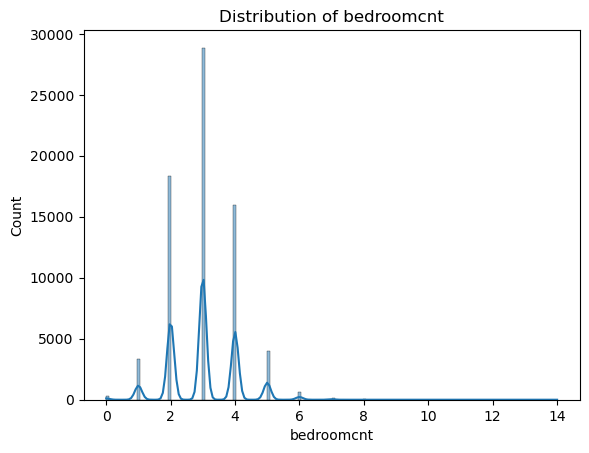


Column: buildingqualitytypeid


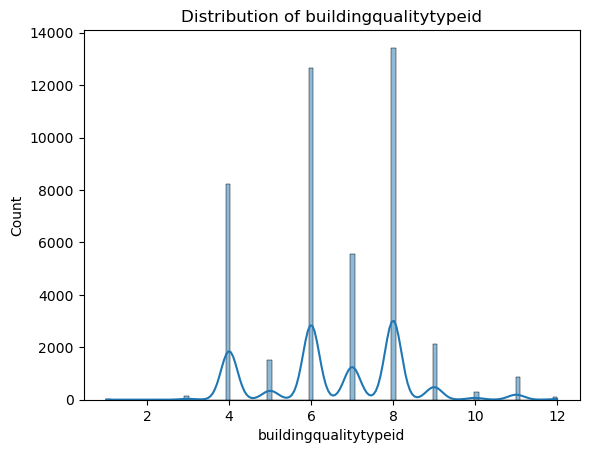


Column: calculatedbathnbr


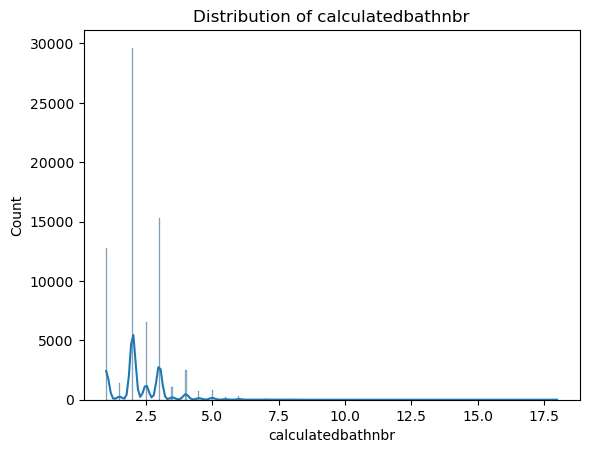


Column: calculatedfinishedsquarefeet


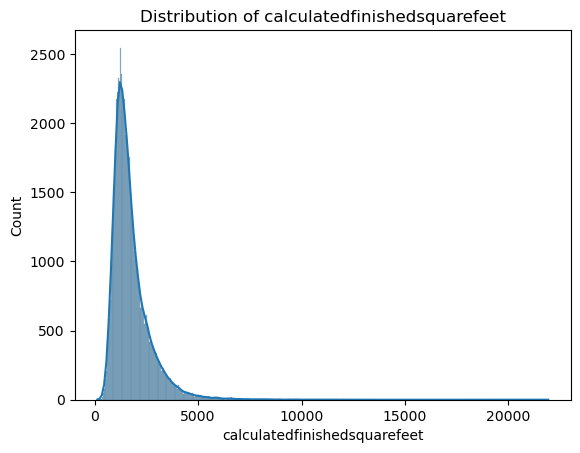


Column: finishedsquarefeet12


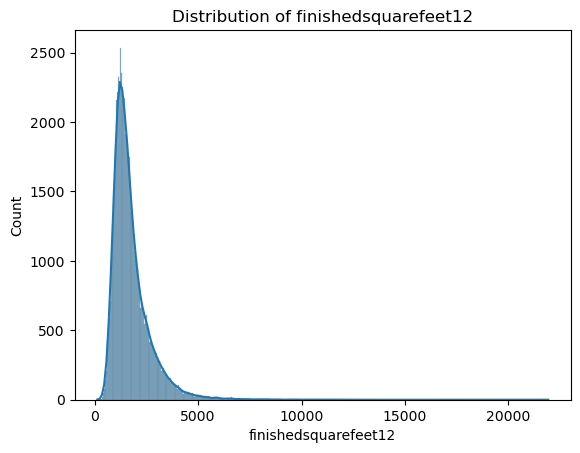


Column: fips


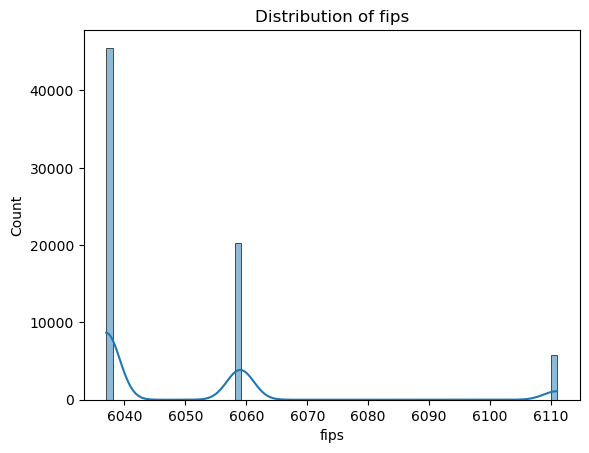


Column: fullbathcnt


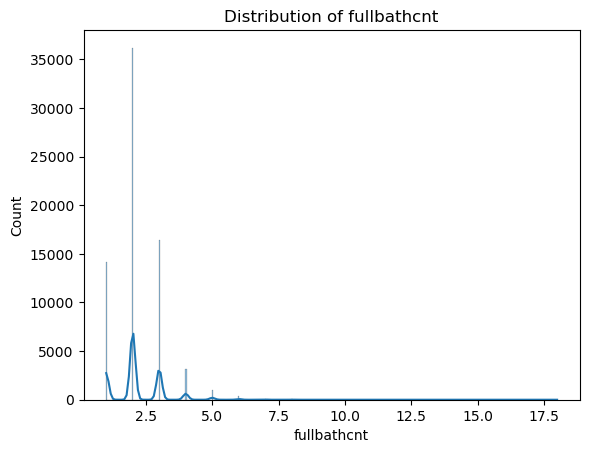


Column: heatingorsystemtypeid


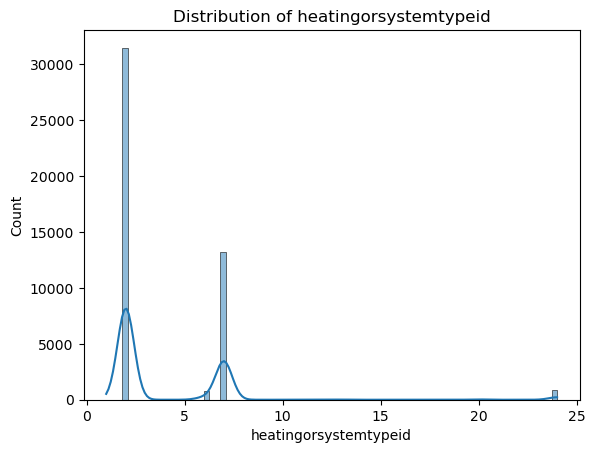


Column: latitude


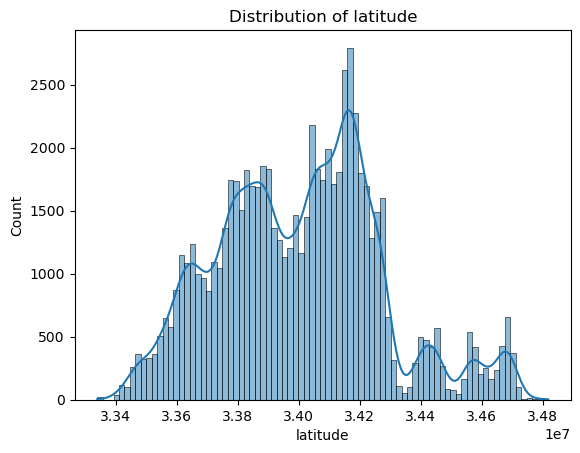


Column: longitude


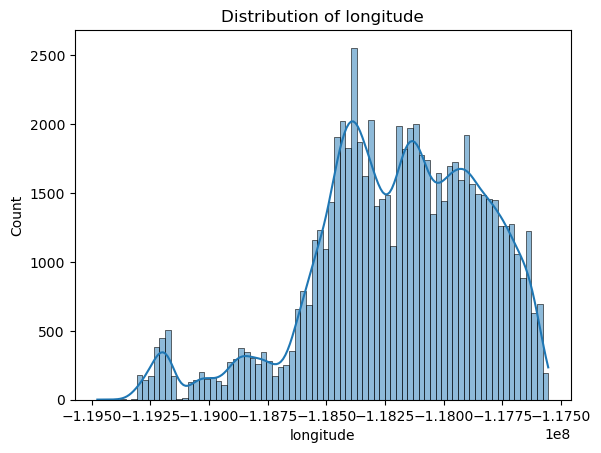


Column: lotsizesquarefeet


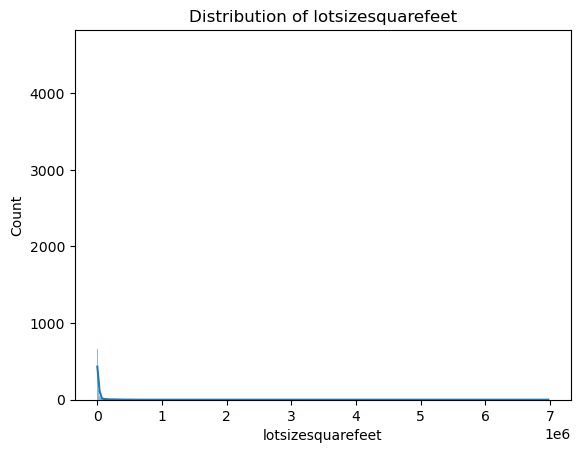


Column: propertycountylandusecode

Column: propertylandusetypeid


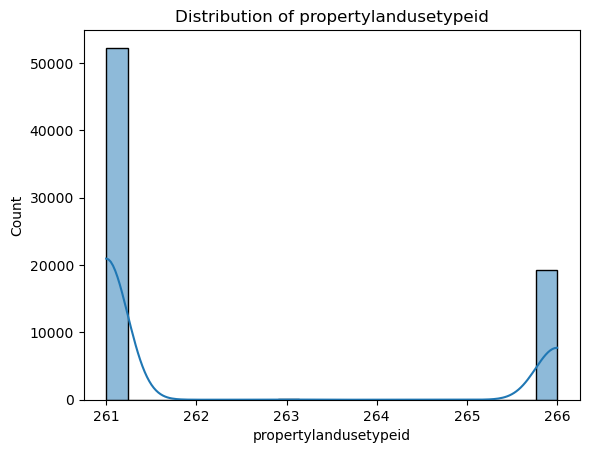


Column: propertyzoningdesc

Column: rawcensustractandblock


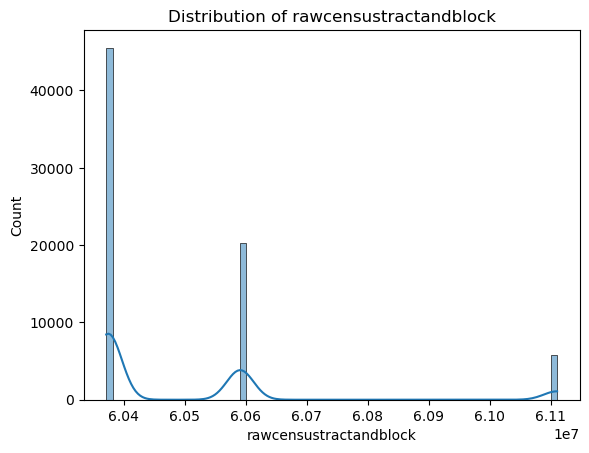


Column: regionidcity


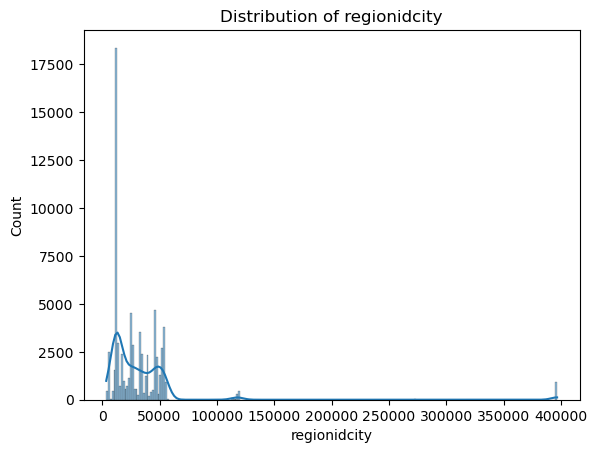


Column: regionidcounty


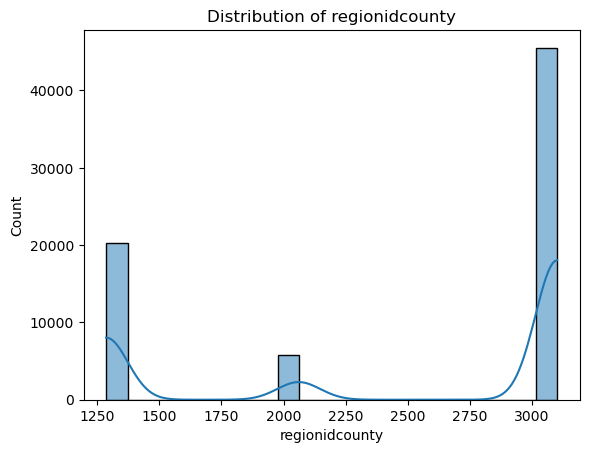


Column: regionidzip


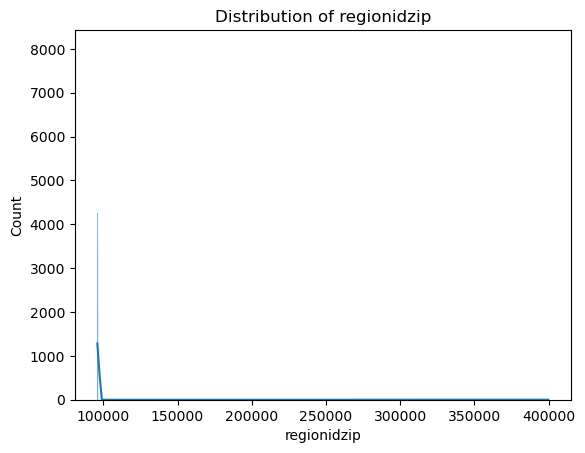


Column: roomcnt


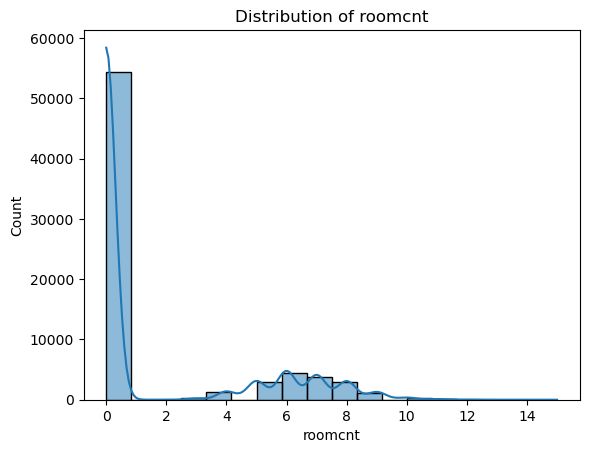


Column: unitcnt


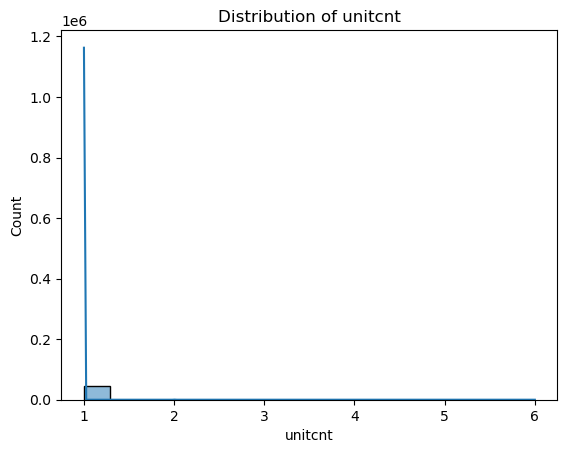


Column: yearbuilt


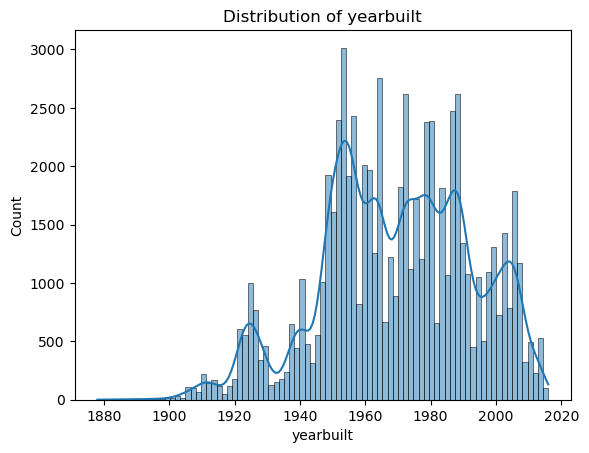


Column: structuretaxvaluedollarcnt


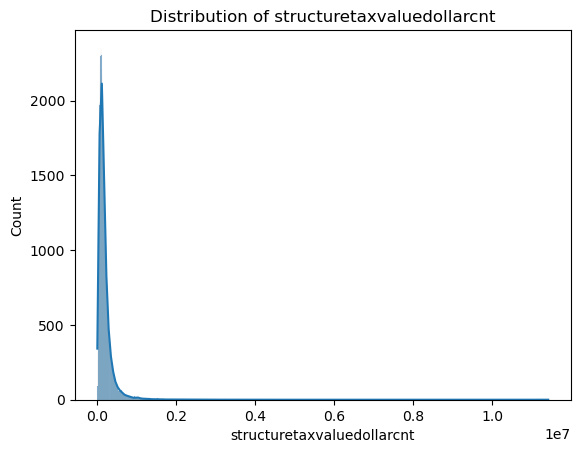


Column: taxvaluedollarcnt


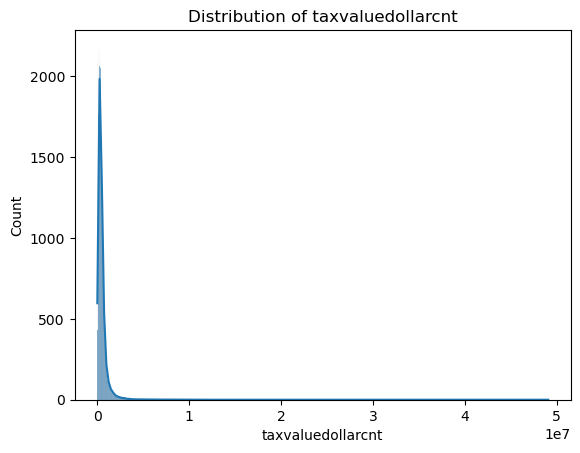


Column: assessmentyear


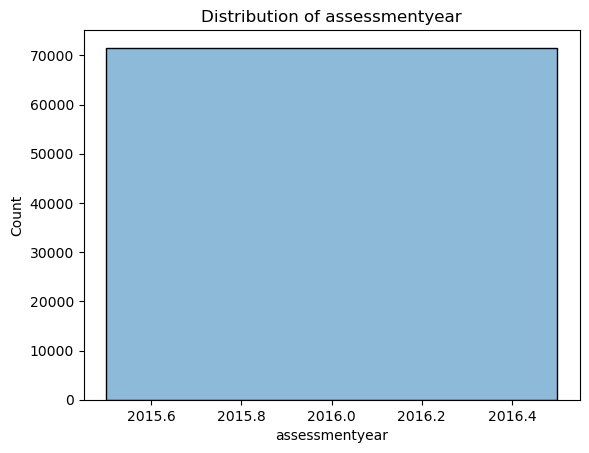


Column: landtaxvaluedollarcnt


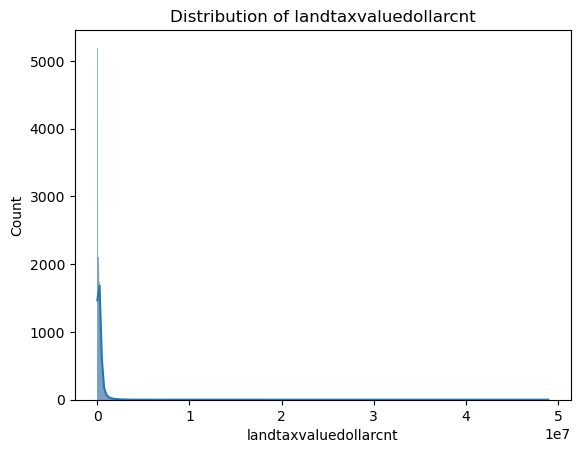


Column: taxamount


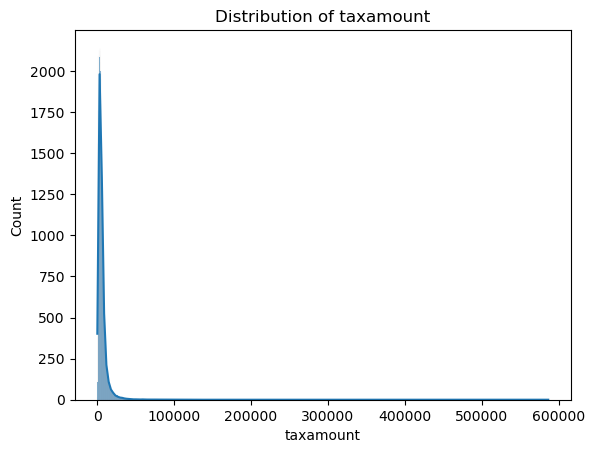


Column: censustractandblock


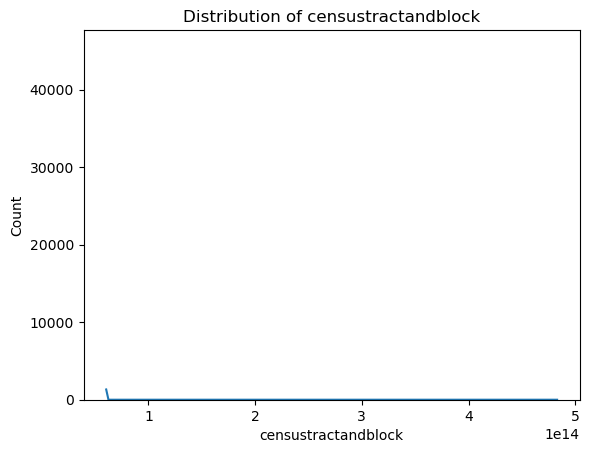


Column: logerror


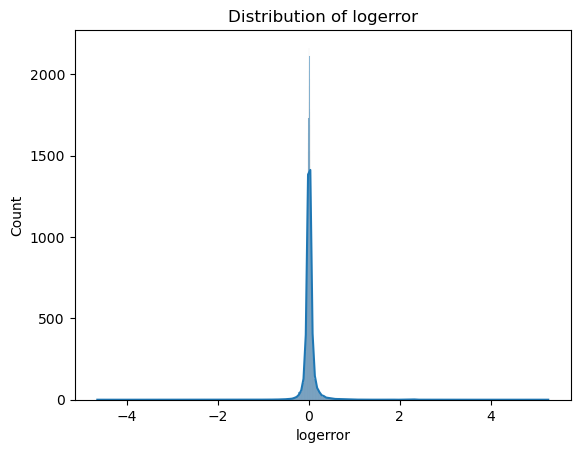


Column: transactiondate

Column: heatingorsystemdesc

Column: propertylandusedesc


In [11]:
# Get the custom describe output
custom_desc_df = custom_describe(df)

In [12]:
# Display the custom describe DataFrame with left-aligned column names
display(custom_desc_df.style.set_properties(**{'text-align': 'left'}))

,num_rows_missing,pct_rows_missing,count,count_nulls,pct_nulls,mean,std,min,25%,50%,75%,max,unique,top,freq,dtype
id,0.000000,0.000000,71561.000000,0,0.000000,1495404.086276,860469.434441,349.000000,754045.000000,1499142.000000,2240178.000000,2982274.000000,nan,nan,nan,int64
parcelid,0.000000,0.000000,71561.000000,0,0.000000,13032608.159710,3245814.922570,10711855.000000,11536518.000000,12570847.000000,14249672.000000,167688532.000000,nan,nan,nan,int64
bathroomcnt,0.000000,0.000000,71561.000000,0,0.000000,2.266563,0.949474,0.000000,2.000000,2.000000,3.000000,18.000000,nan,nan,nan,float64
bedroomcnt,0.000000,0.000000,71561.000000,0,0.000000,3.007644,1.023213,0.000000,2.000000,3.000000,4.000000,14.000000,nan,nan,nan,float64
buildingqualitytypeid,26610.000000,37.185059,44951.000000,26610,37.185059,6.589286,1.694967,1.000000,6.000000,6.000000,8.000000,12.000000,nan,nan,nan,float64
calculatedbathnbr,88.000000,0.122972,71473.000000,88,0.122972,2.268871,0.947184,1.000000,2.000000,2.000000,3.000000,18.000000,nan,nan,nan,float64
calculatedfinishedsquarefeet,22.000000,0.030743,71539.000000,22,0.030743,1752.131341,933.927566,128.000000,1164.000000,1512.000000,2067.000000,21929.000000,nan,nan,nan,float64
finishedsquarefeet12,201.000000,0.280879,71360.000000,201,0.280879,1753.501598,933.928023,128.000000,1166.000000,1514.000000,2068.000000,21929.000000,nan,nan,nan,float64
fips,0.000000,0.000000,71561.000000,0,0.000000,6049.187924,20.720119,6037.000000,6037.000000,6037.000000,6059.000000,6111.000000,nan,nan,nan,float64
fullbathcnt,88.000000,0.122972,71473.000000,88,0.122972,2.198313,0.928396,1.000000,2.000000,2.000000,3.000000,18.000000,nan,nan,nan,float64


In [ ]:
# Display the custom_describe DataFrame
custom_desc_df

In [ ]:
# Assuming you have the Zillow data in the 'df' variable and custom_describe DataFrame from previous steps
custom_desc_df = custom_describe(df)

In [ ]:
# Display the custom_describe DataFrame
custom_desc_df

In [14]:
import numpy as np
import pandas as pd
import scipy.stats as stats

def distribution_type(column):
    if not np.issubdtype(column.dtype, np.number):
        return None
    
    _, p_value = stats.normaltest(column.dropna())
    return 'Normal' if p_value > 0.05 else 'Non-normal'

def column_skewness(column):
    if not np.issubdtype(column.dtype, np.number):
        return None
    return stats.skew(column.dropna())

def skew_type(column):
    skew = column_skewness(column)
    if skew is None:
        return None
    if skew > 0:
        return 'Right'
    elif skew < 0:
        return 'Left'
    else:
        return 'Symmetric'

def data_type(column):
    if not np.issubdtype(column.dtype, np.number):
        return None
    unique_count = column.nunique()
    if unique_count / len(column) < 0.05:
        return 'Discrete'
    else:
        return 'Continuous'

In [16]:
def iqr_outliers(column):
    if not np.issubdtype(column.dtype, np.number):
        return None
    
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((column < lower_bound) | (column > upper_bound)).sum()

In [17]:
# Add the 'distribution_type' column to the custom_describe DataFrame
custom_desc_df['distribution_type'] = df.apply(distribution_type)

# Add the 'num_outliers' column to the custom_describe DataFrame
custom_desc_df['num_outliers'] = df.apply(iqr_outliers)

# Add skewness, skew type, and data type columns to the custom_describe DataFrame
custom_desc_df['skewness'] = df.apply(column_skewness)
custom_desc_df['skew_type'] = df.apply(skew_type)
custom_desc_df['data_type'] = df.apply(data_type)

In [18]:
# Display the custom describe DataFrame with left-aligned column names
display(custom_desc_df.style.set_properties(**{'text-align': 'left'}))

,num_rows_missing,pct_rows_missing,count,count_nulls,pct_nulls,mean,std,min,25%,50%,75%,max,unique,top,freq,dtype,distribution_type,skewness,skew_type,data_type
id,0.000000,0.000000,71561.000000,0,0.000000,1495404.086276,860469.434441,349.000000,754045.000000,1499142.000000,2240178.000000,2982274.000000,nan,nan,nan,int64,Non-normal,-0.008019,Left,Continuous
parcelid,0.000000,0.000000,71561.000000,0,0.000000,13032608.159710,3245814.922570,10711855.000000,11536518.000000,12570847.000000,14249672.000000,167688532.000000,nan,nan,nan,int64,Non-normal,33.154057,Right,Continuous
bathroomcnt,0.000000,0.000000,71561.000000,0,0.000000,2.266563,0.949474,0.000000,2.000000,2.000000,3.000000,18.000000,nan,nan,nan,float64,Non-normal,1.328390,Right,Discrete
bedroomcnt,0.000000,0.000000,71561.000000,0,0.000000,3.007644,1.023213,0.000000,2.000000,3.000000,4.000000,14.000000,nan,nan,nan,float64,Non-normal,0.324799,Right,Discrete
buildingqualitytypeid,26610.000000,37.185059,44951.000000,26610,37.185059,6.589286,1.694967,1.000000,6.000000,6.000000,8.000000,12.000000,nan,nan,nan,float64,Non-normal,0.048363,Right,Discrete
calculatedbathnbr,88.000000,0.122972,71473.000000,88,0.122972,2.268871,0.947184,1.000000,2.000000,2.000000,3.000000,18.000000,nan,nan,nan,float64,Non-normal,1.345870,Right,Discrete
calculatedfinishedsquarefeet,22.000000,0.030743,71539.000000,22,0.030743,1752.131341,933.927566,128.000000,1164.000000,1512.000000,2067.000000,21929.000000,nan,nan,nan,float64,Non-normal,2.893251,Right,Continuous
finishedsquarefeet12,201.000000,0.280879,71360.000000,201,0.280879,1753.501598,933.928023,128.000000,1166.000000,1514.000000,2068.000000,21929.000000,nan,nan,nan,float64,Non-normal,2.896112,Right,Continuous
fips,0.000000,0.000000,71561.000000,0,0.000000,6049.187924,20.720119,6037.000000,6037.000000,6037.000000,6059.000000,6111.000000,nan,nan,nan,float64,Non-normal,2.037556,Right,Discrete
fullbathcnt,88.000000,0.122972,71473.000000,88,0.122972,2.198313,0.928396,1.000000,2.000000,2.000000,3.000000,18.000000,nan,nan,nan,float64,Non-normal,1.407486,Right,Discrete
